### Dependencies

In [1]:
!pip install matplotlib tensorflow tensorflow_addons tensorflow_datasets imageio

### Setup

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf

from IPython import display

### Dataset

(60000, 32, 32, 1)


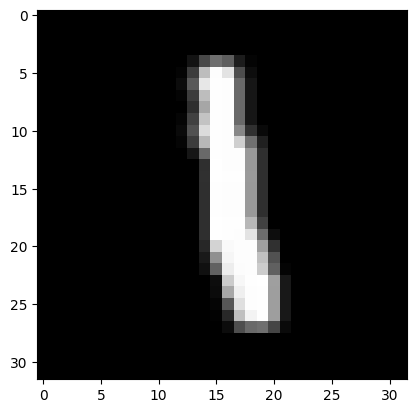

In [97]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = tf.image.resize(train_images, (32,32)) # if we want to resize 
train_images = tf.expand_dims(train_images, -1)
train_images = tf.image.resize(train_images, (32,32))
print(train_images.shape)
plt.imshow(train_images[6, :, :, 0], cmap='gray')

#### Note: 

Non-grayscale image should be normalized to [-1,1]

In [98]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [99]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator network

#### Note:

Modify the network size for deployment

In [106]:
class Generator(Model):

    def __init__(self, noise_dim, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.noise_dim = noise_dim
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = int(min(max(min(image_shape[0]/8.0-3.0, image_shape[1]/8.0-3.0), 5.0), 11.0))

        self.lr_d = layers.ReLU()
        self.lr_c1 = layers.ReLU()
        self.lr_c2 = layers.ReLU()
        self.lr_c3 = layers.ReLU()
        
        self.init_dense = layers.Dense(image_shape[0]/8.0*image_shape[1]/8.0*64,
                               use_bias=False, input_shape=(self.noise_dim,))
        
        self.init_reshape = layers.Reshape((int(image_shape[0]/8.0), int(image_shape[1]/8.0), 64))
        
        self.conv2dT1 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same', use_bias=False)
        self.conv2dT2 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', use_bias=False)
        self.conv2dT3 = layers.Conv2DTranspose(8, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', use_bias=False)
        self.conv2dTactv = layers.Conv2DTranspose(self.num_channel, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', use_bias=False, activation='tanh')

    def call(self, noise_vec):

        init_vec = tf.squeeze(self.lr_d(self.init_dense(noise_vec)))
        
#         print(init_vec.shape)
        
        reshaped = self.init_reshape(init_vec)
        
#         print(reshaped.shape)
        
        convt1 = self.lr_c1(self.conv2dT1(reshaped))

#         print(convt1.shape)
        
        convt2 = self.lr_c2(self.conv2dT2(convt1))
        
#         print(convt2.shape)
                         
        convt3 = self.lr_c3(self.conv2dT3(convt2))
        
#         print(convt3.shape)
            
        out = self.conv2dTactv(convt3)
        
#         print(out.shape)

        return out

#### Testing

In [107]:
g1 = Generator(10, (32, 32), 3)

In [108]:
g1.kernel_size

5

In [109]:
noise_input = tf.random.normal((5, 10))
print(noise_input.shape)
pics1 = g1(tf.expand_dims(noise_input, 0))
print(pics1.shape)
# plt.imshow(pics1[-1, :, :, :], cmap='gray')

(5, 10)
(5, 32, 32, 3)


In [110]:
g1.summary()

Model: "generator_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 re_lu (ReLU)                multiple                  0         
                                                                 
 re_lu_1 (ReLU)              multiple                  0         
                                                                 
 re_lu_2 (ReLU)              multiple                  0         
                                                                 
 re_lu_3 (ReLU)              multiple                  0         
                                                                 
 dense_58 (Dense)            multiple                  10240     
                                                                 
 reshape_30 (Reshape)        multiple                  0         
                                                                 
 conv2d_transpose_120 (Conv2  multiple                

### Discriminator

In [196]:
class Discriminator(Model):

    def __init__(self, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = int(min(max(min(image_shape[0]/8.0-3.0, image_shape[1]/8.0-3.0), 5.0), 11.0))

        self.lr_c1 = layers.LeakyReLU()
        self.lr_c2 = layers.LeakyReLU()
        self.lr_c3 = layers.LeakyReLU()
        self.flatten = layers.Flatten()
        
        self.conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                        strides=(2, 2), padding='same',
                                        input_shape=(None, self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        self.conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2d3 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.dense_actv = layers.Dense(16,
#                                       )
                                       activation="relu")
        
    def call(self, img_input):
        
        conv1 = self.lr_c1(self.conv2d1(img_input))
        
#         print(conv1.shape)
        
        conv2 = self.lr_c2(self.conv2d2(conv1))
        
#         print(conv2.shape)
                         
        conv3 = self.lr_c3(self.conv2d3(conv2))
        
#         print(conv3.shape)
        
        flat = self.flatten(conv3)
        
#         print(flat.shape)
        
        out = tf.squeeze(self.dense_actv(flat))
        
#         print(out.shape)

        return out

#### Testing

In [197]:
d1 = Discriminator((32,32), 3)
g2 = Generator(10, (32,32), 3)
d1.kernel_size

5

In [198]:
noise_input = tf.random.normal((5, 10))
pics2 = g1(tf.expand_dims(noise_input, 0))
# plt.imshow(pics2[-1, :, :, 0], cmap='gray')
print(pics2.shape)

(5, 32, 32, 1)


In [199]:
deci = d1(pics2)
deci

<tf.Tensor: shape=(5, 16), dtype=float32, numpy=
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.03308315e-04,
        2.75322178e-04, 8.43335001e-04, 1.64440600e-04, 5.17988752e-04,
        0.00000000e+00, 3.10381729e-05, 0.00000000e+00, 0.00000000e+00,
        2.95469625e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.67269905e-04, 0.00000000e+00, 0.00000000e+00,
        2.19586829e-04, 0.00000000e+00, 2.34760737e-04, 3.86910135e-04,
        0.00000000e+00, 2.67366326e-04, 0.00000000e+00, 0.00000000e+00,
        2.77092768e-04, 0.00000000e+00, 0.00000000e+00, 4.84769116e-05],
       [0.00000000e+00, 6.45680353e-04, 0.00000000e+00, 1.07352249e-03,
        5.41112095e-04, 0.00000000e+00, 1.46461040e-04, 0.00000000e+00,
        1.31542838e-04, 1.05469383e-03, 0.00000000e+00, 0.00000000e+00,
        8.19663925e-04, 0.00000000e+00, 6.17938815e-04, 0.00000000e+00],
       [0.00000000e+00, 8.33364538e-05, 1.17837451e-04, 2.64599017e-04,
        2.70

In [200]:
d1.summary()

Model: "discriminator_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 leaky_re_lu_297 (LeakyReLU)  multiple                 0         
                                                                 
 leaky_re_lu_298 (LeakyReLU)  multiple                 0         
                                                                 
 leaky_re_lu_299 (LeakyReLU)  multiple                 0         
                                                                 
 flatten_59 (Flatten)        multiple                  0         
                                                                 
 conv2d_177 (Conv2D)         multiple                  416       
                                                                 
 conv2d_178 (Conv2D)         multiple                  12832     
                                                                 
 conv2d_179 (Conv2D)         multiple             

### DCGAN

In [418]:
EPSILON = 1e-16

class DCGAN:
    
    def __init__(self, dataset, image_shape, num_channel, noise_latent_dim,
                 buffer_size=60000, batch_size=256, lr=3e-4, gp_lam = 10.0):
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        assert len(dataset.shape) == 4
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.noise_latent_dim = noise_latent_dim
        self.buffer_cap, self.batch_size, self.gp_lam = buffer_size, batch_size, gp_lam
        self.num_img_prog_monit = 16
        
        self.dataset = tf.data.Dataset.from_tensor_slices(tf.image.resize(dataset,
                                                                          self.image_shape)).shuffle(self.buffer_cap).batch(self.batch_size)
        # NOTE: Dataset must be processed differently for different source and applications
        
        self.g = Generator(self.noise_latent_dim, self.image_shape, self.num_channel)
        self.d = Discriminator(self.image_shape, self.num_channel)
        
        self.g_opt = tf.keras.optimizers.Adam(lr)
        self.d_opt = tf.keras.optimizers.Adam(lr)
        
        self.g_seed = tf.random.normal((self.num_img_prog_monit, self.noise_latent_dim))

    def cramer_loss(self, d_x_data, d_g_z_1, d_g_z_2, x_it):
        
        crit_r = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(d_x_data, -d_g_z_2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(d_x_data**2, axis = 1)+EPSILON))
        crit_g_1 = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(d_g_z_1, -d_g_z_2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(d_g_z_1**2, axis = 1)+EPSILON))
        
        L_srg = tf.math.add(crit_r, -crit_g_1)
        
        with tf.GradientTape() as t_gp:
            t_gp.watch(x_it)
            d_it = self.d(x_it)
            crit_it = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(d_it, -d_g_z_2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(d_it**2, axis = 1)+EPSILON))
            
        gp_grad = t_gp.gradient(crit_it, x_it)
        l2n_gp = tf.math.sqrt(tf.reduce_sum(gp_grad**2, axis = [1,2,3])+EPSILON)
        
        # d_loss
        L_d = -L_srg + (self.gp_lam*((l2n_gp-1.0)**2))

        l2nrg1 = tf.math.sqrt(tf.reduce_sum(tf.math.add(d_x_data, -d_g_z_1)**2, axis = 1)+EPSILON)
        l2nrg2 = tf.math.sqrt(tf.reduce_sum(tf.math.add(d_x_data, -d_g_z_2)**2, axis = 1)+EPSILON)
        l2ng12 = tf.math.sqrt(tf.reduce_sum(tf.math.add(d_g_z_1, -d_g_z_2)**2, axis = 1)+EPSILON)

        # g_loss
        L_g = (l2nrg1 + l2nrg2 - l2ng12)

        return L_g, L_d
        
    
    @tf.function
    def update(self, imgs):
        noise_input1 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        noise_input2 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            g_z_1 = self.g(noise_input1)
            g_z_2 = self.g(noise_input2)
            
            d_x_data = self.d(imgs)
            d_g_z_1 = self.d(g_z_1)
            d_g_z_2 = self.d(g_z_2)
            
            epsi = tf.random.uniform([imgs.shape[0], 1, 1, 1], 0.0, 1.0)
            x_it = tf.math.add(epsi*imgs, (1.0-epsi)*g_z_1)
            g_loss, d_loss = self.cramer_loss(d_x_data, d_g_z_1, d_g_z_2, x_it)
            
        grad_g = g_tape.gradient(g_loss, self.g.trainable_variables)
        grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)
        
        self.g_opt.apply_gradients(zip(grad_g, self.g.trainable_variables))
        self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
        return g_loss, d_loss
        
    def train(self, epochs=50):
        for epo in range(epochs):
            for img_b in self.dataset:
                g_l, d_l = self.update(img_b)
                print("Generator Loss: ", tf.reduce_mean(g_l), ", Discriminator Loss: ",  tf.reduce_mean(d_l))
            
            self.monitor_progress(epo)
            
    def monitor_progress(self, epo):
        pics = self.g(self.g_seed)
        
        fig = plt.figure(figsize=(4,4))
        for i in range(pics.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(pics[i,:,:,0]*127.5+127.5,cmap='gray')
            plt.axis('off')
            
        plt.savefig('/Users/anthonylaw/Desktop/Hustle/GAN-devel/imgs/image_{:04d}.png'.format(epo))
#         plt.savefig('/home/tony/TO_BE_REMOVED/imgs/image_{:04d}.png'.format(epo))
        # NEEDS to be changed for machines
        
        plt.close('all')
        

#### Testing

In [419]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = tf.expand_dims(train_images, -1)

In [420]:
dcgan1 = DCGAN(train_images, (32,32), 1, 100)
d1 = Discriminator((32,32), 1)
g1 = Generator(10, (32,32), 1)

In [421]:
noise_input1 = tf.random.normal((256, 10))
noise_input2 = tf.random.normal((256, 10))
noise_input3 = tf.random.normal((256, 10))
pics3 = g1(tf.expand_dims(noise_input1, 0))
pics4 = g1(tf.expand_dims(noise_input2, 0))
pics5 = g1(tf.expand_dims(noise_input3, 0))
d_pics3 = d1(pics3)
d_pics4 = d1(pics4)
d_pics5 = d1(pics5)

In [422]:
dcgan1.train(1000)

Generator Loss:  tf.Tensor(23.470701, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(9.996649, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(18.870422, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(9.97958, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(13.590427, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(9.975534, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(10.111435, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(9.923632, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8.526406, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(9.886454, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(7.339521, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(9.857141, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(4.6010294, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(9.753372, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(3.4411967, shape=(), dtype=float32) , Discriminator Loss:  

Generator Loss:  tf.Tensor(9.496759, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-0.25217298, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(10.761937, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1.7246964, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(12.355995, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-2.6886337, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(13.223896, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-3.9232416, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(14.640501, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-4.8274627, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(15.681966, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-5.9438014, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(17.519495, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-6.440108, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(17.744982, shape=(), dtype=float32) , Discr

Generator Loss:  tf.Tensor(157.94167, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-111.573746, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(165.56006, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-107.488144, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(174.68246, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-155.71011, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(183.72069, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-157.80272, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(194.23047, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-150.66296, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(204.11919, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-162.07004, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(214.3354, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-174.3628, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(226.1831, shape=(), dtype=float32) , Discr

Generator Loss:  tf.Tensor(2114.9424, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1533.4758, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(2177.8955, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1059.3663, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(2252.0374, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1442.0222, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(2309.0732, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1562.6724, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(2364.3938, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1936.5146, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(2429.508, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1393.4663, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(2494.9578, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-1864.859, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(2564.5044, shape=(), dtype=float32) , Discri

Generator Loss:  tf.Tensor(5626.6177, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-3147.6953, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(5601.41, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-3629.3271, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(5622.868, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-2787.2012, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(5688.8633, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-3296.2075, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(5705.8604, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-2398.6855, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(5681.4863, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-2890.5903, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(5643.4233, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-3554.3354, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(5651.3286, shape=(), dtype=float32) , Discrim

Generator Loss:  tf.Tensor(8099.802, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-5314.875, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8187.788, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-5140.219, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8313.512, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-5267.4814, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8419.41, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-4731.91, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8484.598, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-5137.982, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8515.738, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-5688.8447, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8565.021, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-5739.459, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(8658.326, shape=(), dtype=float32) , Discriminator Loss:

Generator Loss:  tf.Tensor(14983.3125, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-9416.023, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(15098.0, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-9853.268, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(15300.721, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-11108.475, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(15534.808, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-8594.204, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(15732.918, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-10862.41, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(15921.43, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-8736.645, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(16075.26, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-9566.092, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(16250.765, shape=(), dtype=float32) , Discriminator

Generator Loss:  tf.Tensor(28442.027, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-17363.053, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(28556.29, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-16875.768, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(28961.465, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-17100.62, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(29218.318, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-17212.117, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(29473.242, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-17652.135, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(29646.59, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-17633.648, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(29628.047, shape=(), dtype=float32) , Discriminator Loss:  tf.Tensor(-17177.32, shape=(), dtype=float32)
Generator Loss:  tf.Tensor(29919.566, shape=(), dtype=float32) , Discrimi

KeyboardInterrupt: 